# Companion Notebook to `playing-with-coronavirus-data` 
- [GitHub Repo](https://github.com/jirvingphd/playing-with-coronavirus-data)
- James M. Irivng, Ph.D.
- james.irving.phd@gmail.com

# Business Problem

- Covid-19 and the various strains that have since emerged has upended modern life and fundamental changed how we function as a society.
- Part of what has made it difficult to tackle the pandemic is due to differences between states, state laws/policies, and a lack of public understanding about the predictability of the surges in cases. 


### Goal

- The goal of this notebook is to produce a workflow for producing forecasts of the following metrics at least 1 week ahead of time. 
    - Confirmed Cases
    - Number of Deaths
    - ICU Capacity
    
- The stretch goal for the project is to create a streamlit dashboard for getting state-level forecasts for any state in the US, using fresh daily data.
    

### Methodology

- To select 3-5 prototypical states representing very different time courses/
- Initial Thoughts:
    - NY
    - TX
    - FL
    - MD
    - LA

# Data

- See `Data Acquisition.py` and `Replacing Covid Tracking Project Data_08-2021.ipynb` for details (for now)


In [1]:
# !pip install fsds
# !pip install pmdarima

from fsds.imports import *
import os,glob,sys
import re

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_dark"

plt.rcParams['figure.figsize'] = (12,6)
pd.set_option('display.max_columns',0)

fsds v0.3.2 loaded.  Read the docs: https://fs-ds.readthedocs.io/en/latest/ 


Handle,Package,Description
dp,IPython.display,Display modules with helpful display and clearing commands.
fs,fsds,Custom data science bootcamp student package
mpl,matplotlib,Matplotlib's base OOP module with formatting artists
plt,matplotlib.pyplot,Matplotlib's matlab-like plotting module
np,numpy,scientific computing with Python
pd,pandas,High performance data structures and tools
sns,seaborn,High-level data visualization library based on matplotlib


> Data is stored as both separate csvs for each state as well as one big dictionary in a joblib file.

#### CSV Data

In [2]:
import glob
query = "./data/combined_*.csv.gz"
# os.listdir('data/')
file_list = glob.glob(query)
file_list[:5]

['./data/combined_data_PR.csv.gz',
 './data/combined_data_FL.csv.gz',
 './data/combined_data_NV.csv.gz',
 './data/combined_data_MD.csv.gz',
 './data/combined_data_KS.csv.gz']

#### Joblib Data

In [3]:
import joblib
STATES = joblib.load('data/STATE_DICT.joblib')
STATES.keys()

dict_keys(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'])

# EDA

## Selecting Prototypical States

In [11]:
def get_state(STATES, state='NY'):
    df_state= STATES[state].copy()
    cols_to_drop=[c for c in df_state.columns if ('coverage' in c) | ('denominator' in c)]
    df_state = df_state.drop(columns=cols_to_drop)
    return df_state

### NY

In [12]:
ny = get_state(STATES,'NY')
ny

,# Cases,# Deaths,inpatient_beds_utilization,inpatient_beds_utilization_numerator,adult_icu_bed_utilization,adult_icu_bed_utilization_numerator
date,,,,,,
2020-01-22,0.0,0.0,0.000000,0.0,0.000000,0.0
2020-01-23,0.0,0.0,0.000000,0.0,0.000000,0.0
2020-01-24,0.0,0.0,0.000000,0.0,0.000000,0.0
2020-01-25,0.0,0.0,0.000000,0.0,0.000000,0.0
2020-01-26,0.0,0.0,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...
2021-08-04,2926.0,6.0,0.782515,40028.0,0.649326,3370.0
2021-08-05,3536.0,15.0,0.784360,39960.0,0.651638,3382.0
2021-08-06,3739.0,3.0,0.781316,39751.0,0.658052,3412.0


In [30]:
## make subplotsplot of time series # of cases vs utilization 
df_state = ny.copy()
drop_cols = [c for c in df_state.columns if ('numerator' in c)| ('denominator' in c)]
df_state.drop(columns=drop_cols,inplace=True)
util_cols = [c for c in df_state.columns if c.endswith('utilization') ]
other_cols = [c for c in df_state.columns if c not in util_cols]
util_cols

['inpatient_beds_utilization', 'adult_icu_bed_utilization']

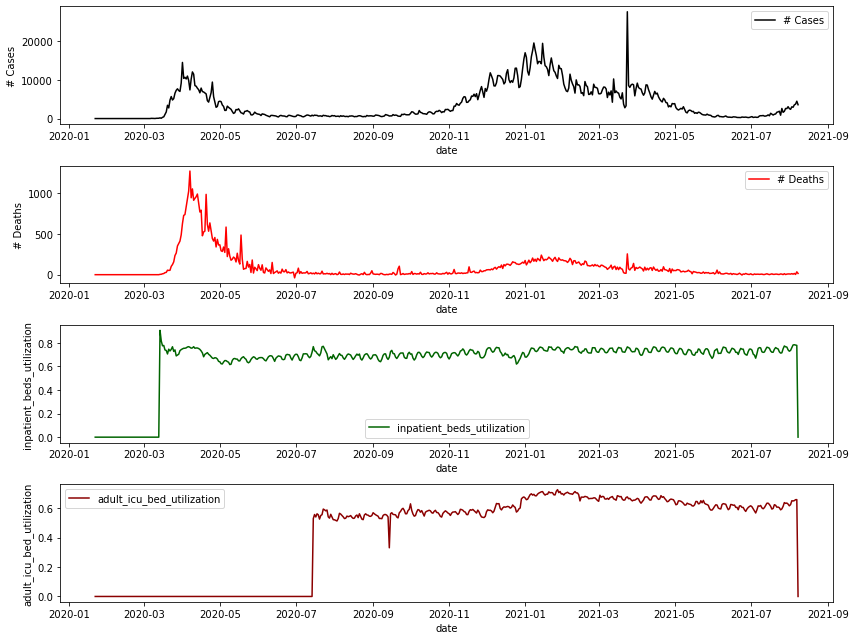

In [38]:
## 3 subplots
fig, axes = plt.subplots(nrows=4,figsize=(12,9))

# 1: cases
sns.lineplot(data = df_state,x=df_state.index,color='black', y='# Cases',
             ax=axes[0],label='# Cases')#.plot(ax=axes[0])
# 2: deaths
sns.lineplot(data = df_state,x=df_state.index,color='red',
             y='# Deaths',ax=axes[1],label='# Deaths')#.plot(ax=axes[0])

# 3: icu utilization
sns.lineplot(data=ny, x=df_state.index, y='inpatient_beds_utilization',
            ax=axes[2], color='darkgreen',label='inpatient_beds_utilization')

# 4: icu utilization
sns.lineplot(data=ny, x=df_state.index, y='adult_icu_bed_utilization',
            ax=axes[3], color='darkred',label='adult_icu_bed_utilization')
plt.tight_layout()

In [6]:
## Appending folder with functions
%load_ext autoreload 
%autoreload 2
import sys
sys.path.append('.')

import functions as fn
# help(fn)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
def plot_state(df_state, title='State Covid Statistics',figsize=(10,8)):
    drop_cols = [c for c in df_state.columns if ('numerator' in c)| ('denominator' in c)]
    df_state.drop(columns=drop_cols,inplace=True)
    util_cols = [c for c in df_state.columns if c.endswith('utilization') ]
    other_cols = [c for c in df_state.columns if c not in util_cols]

    ## 3 subplots
    fig, axes = plt.subplots(nrows=4,figsize=figsize)
    fig.suptitle(title)

    # 1: cases
    sns.lineplot(data = df_state,x=df_state.index,color='black', y='# Cases',
                 ax=axes[0],label='# Cases')#.plot(ax=axes[0])
    # 2: deaths
    sns.lineplot(data = df_state,x=df_state.index,color='red',
                 y='# Deaths',ax=axes[1],label='# Deaths')#.plot(ax=axes[0])

    # 3: icu utilization
    sns.lineplot(data=ny, x=df_state.index, y='inpatient_beds_utilization',
                ax=axes[2], color='darkgreen',label='inpatient_beds_utilization')

    # 4: icu utilization
    sns.lineplot(data=ny, x=df_state.index, y='adult_icu_bed_utilization',
                ax=axes[3], color='darkred',label='adult_icu_bed_utilization')
    plt.tight_layout()
    return fig

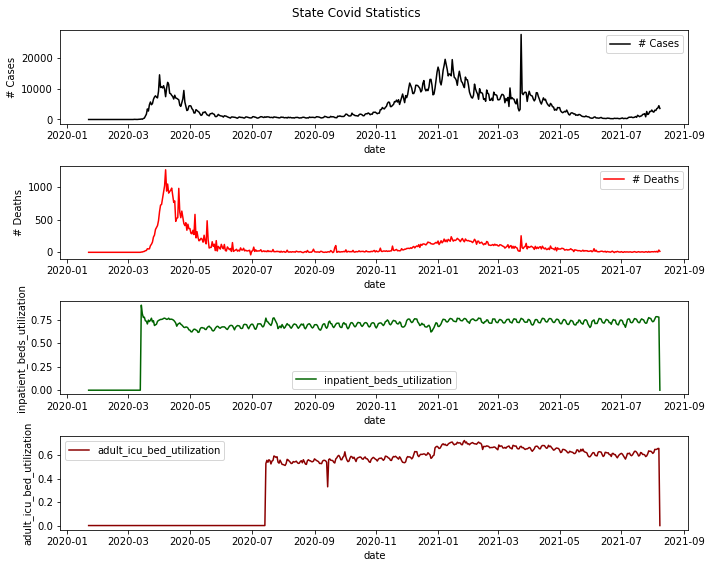

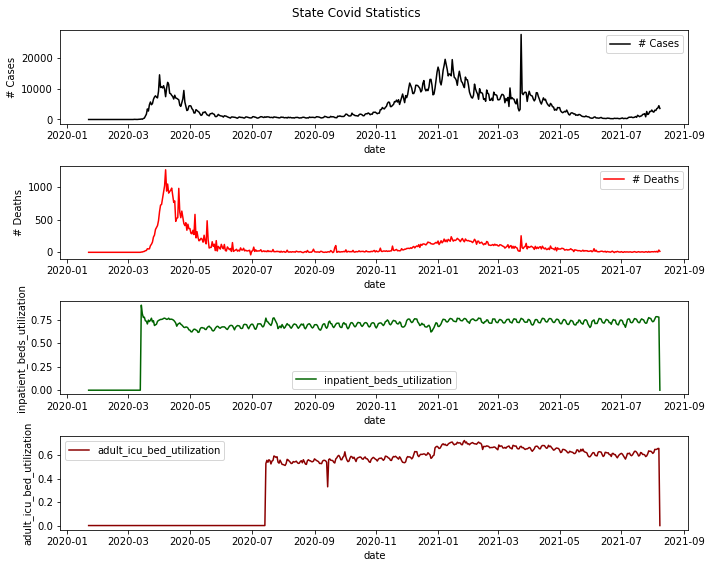

In [49]:
plot_state(ny)

## Old Data

In [19]:
# covid = fn.CovidTrackingProject(verbose=True)
# covid

In [45]:
# covid.df_states

## Updating Workflow Due to CovidTracking Project API shutting down

- Reverting to using Kaggle dataset. 


In [20]:
%load_ext autoreload 
%autoreload 2
import coronavirus_functions as fn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# UPDATING 

In [32]:
cols_to_grab = ['# Cases','# Deaths','inpatient_beds_utilization','adult_icu_bed_utilization']
df_state = STATES['MD'][cols_to_grab].copy()
df_state

,# Cases,# Deaths,inpatient_beds_utilization,adult_icu_bed_utilization
date,,,,
2020-01-22,0.0,0.0,0.000000,0.000000
2020-01-23,0.0,0.0,0.000000,0.000000
2020-01-24,0.0,0.0,0.000000,0.000000
2020-01-25,0.0,0.0,0.000000,0.000000
2020-01-26,0.0,0.0,0.000000,0.000000
...,...,...,...,...
2021-08-04,695.0,5.0,0.844803,0.736719
2021-08-05,729.0,2.0,0.837001,0.726408
2021-08-06,890.0,4.0,0.841025,0.731073


In [28]:


# ## Get df for curr state and resample, keeping the last point for each day
# state_df = df.loc[df['state']==state]
# state_df = state_df.resample('D').last()

# ## save each col into its own dict key
# state_ts_dict = {}
# for col in cols_to_grab:
#     curr_ts = state_df[col].rename(f"{state}-{col}")
#     state_ts_dict[col] = curr_ts
# state_ts_dict

In [31]:
# cols_to_grab = ['Confirmed','Deaths','Recovered']
# state_data = {}
# for state in state_list:

#     ## Get df for curr state and resample, keeping the last point for each day
#     state_df = df.loc[df['state']==state]
#     state_df = state_df.resample('D').last()

#     ## save each col into its own dict key
#     state_ts_dict = {}
#     for col in cols_to_grab:
#         curr_ts = state_df[col].rename(f"{state}-{col}")
#         state_ts_dict[col] = curr_ts
#     state_data[state] = pd.DataFrame(state_ts_dict)

In [33]:
# ## pull out md confirmed
# ts = state_data['MD']#['Confirmed']
# ts

# TEST MODELING

In [35]:
df_state.columns

Index(['# Cases', '# Deaths', 'inpatient_beds_utilization',
       'adult_icu_bed_utilization'],
      dtype='object')

<AxesSubplot:xlabel='date'>

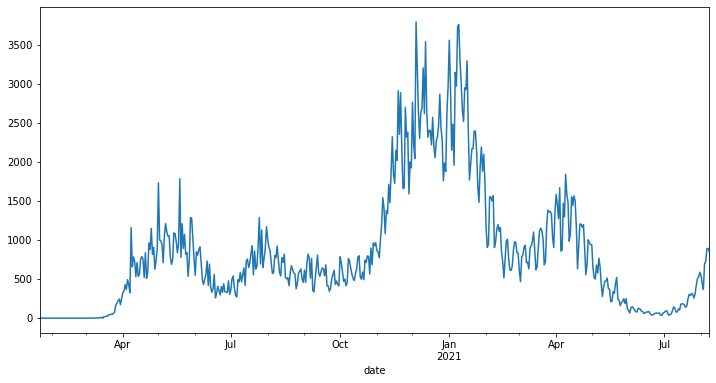

In [37]:
ts = df_state['# Cases']
ts.plot()

<AxesSubplot:xlabel='date'>

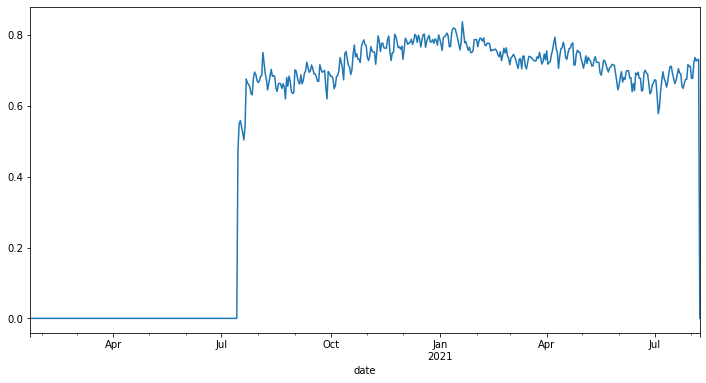

In [39]:
ts2 = df_state['adult_icu_bed_utilization']
ts2.plot()

<AxesSubplot:xlabel='date'>

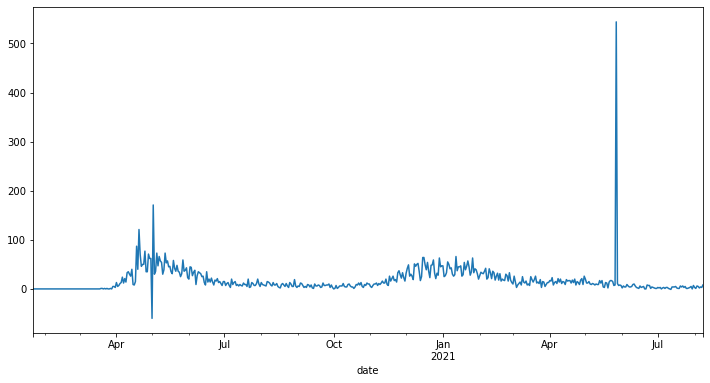

In [38]:
ts3 = df_state['# Deaths']
ts3.plot()

### Checking Seasonal Decompose for Seasonality to Use

In [40]:
ts = df_state['# Cases'].copy()
ts

date
2020-01-22      0.0
2020-01-23      0.0
2020-01-24      0.0
2020-01-25      0.0
2020-01-26      0.0
              ...  
2021-08-04    695.0
2021-08-05    729.0
2021-08-06    890.0
2021-08-07    892.0
2021-08-08    853.0
Freq: D, Name: # Cases, Length: 565, dtype: float64

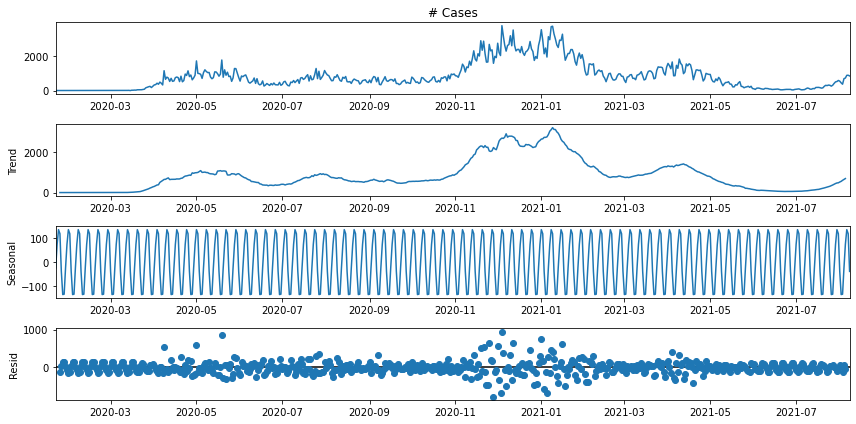

In [41]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sms
decomp = sms.tsa.seasonal_decompose(ts)
decomp.plot();

<AxesSubplot:xlabel='date'>

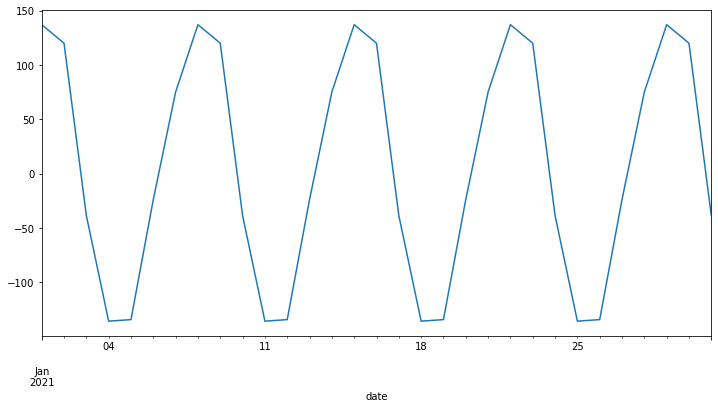

In [46]:
decomp.seasonal.loc['01-2021'].plot()

- Seasonality appears to be ~7 days

In [58]:
# fn.stationarity_check(ts,window=14)

<AxesSubplot:xlabel='date'>

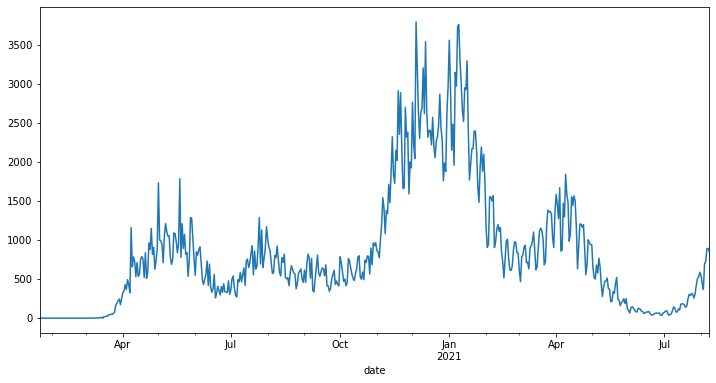

In [61]:
ts.plot()

In [66]:
ts.shape[0]-30

535

In [67]:
## train test spit
# get the tts_cutoff  (the # of timesteps/rows to split at)
tts_cutoff = round(ts.shape[0]*0.9)
tts_cutoff

508

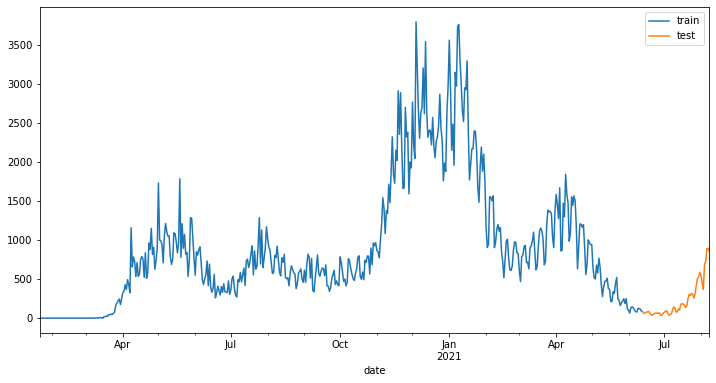

In [68]:
## Use the tts cutoff to do Train test split and plot
train = ts.iloc[:tts_cutoff]
test = ts.iloc[tts_cutoff:]

## Plot
ax = train.plot(label='train')
test.plot(label='test')
ax.legend()

,Test Statistic,#Lags Used,# of Observations Used,p-value,p<.05,Stationary?
AD Fuller Results,-2.073151,15,492,0.255447,False,False


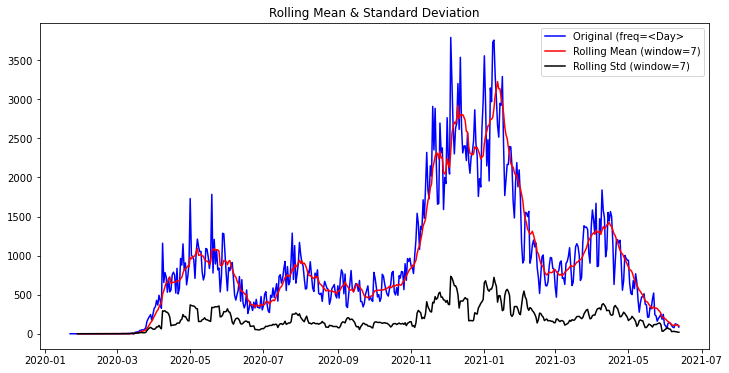

,Test Statistic,#Lags Used,# of Observations Used,p-value,p<.05,Stationary?
AD Fuller Results,-2.073151,15,492,0.255447,False,False


In [71]:
## check staationarity 
fn.stationarity_check(train, window=7)

In [73]:
from pmdarima import auto_arima

auto_model = auto_arima(train,start_p=0,start_q=0,start_P=0,start_Q=0,m=7,trace=True)
auto_model

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=7142.363, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=7067.570, Time=0.25 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=7047.765, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=7140.364, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=7093.117, Time=0.09 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=6955.135, Time=0.68 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=7025.581, Time=0.30 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=6957.009, Time=1.25 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=6956.999, Time=1.37 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=7031.791, Time=0.65 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=7002.623, Time=0.61 sec
 ARIMA(0,1,1)(2,0,2)[7] intercept   : AIC=inf, Time=2.08 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=7083.196, Time=0.44 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=6956.533, Time=1.03 sec
 ARIMA(0,1,2)(1,0,1)[7] intercept   : 

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(1, 0, 1, 7),
      suppress_warnings=True, with_intercept=False)

In [77]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  508
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -3472.575
Date:                           Mon, 09 Aug 2021   AIC                           6953.150
Time:                                   19:31:39   BIC                           6970.064
Sample:                                        0   HQIC                          6959.783
                                           - 508                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5763      0.027    -21.205      0.000      -0.630      -0.523
ar.S.L7        0.9626      0.023     41.630      0.000       0.917       1.008
ma.S.L7       -0.8218      0.042    -19.351      0.000      -0.905      -0.739
sigma2      5.162e+04   1747.087     29.545      0.000    4.82e+04     5.5e+04
===================================================================================
Ljung-Box (Q):                       80.87   Jarque-Bera (JB):               970.61
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.85   Skew:                             0.89
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                           # Cases   No. Observations:                  508
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -3472.575
Date:                           Mon, 09 Aug 2021   AIC                           6953.150
Time:                                   19:31:52   BIC                           6970.064
Sample:                               01-22-2020   HQIC                          6959.783
                                    - 06-12-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5763      0.027    -21.205      0.000      -0.630      -0.523
ar.S.L7        0.9627      0.023     41.633      0.000       0.917       1.008
ma.S.L7       -0.8219      0.042    -19.354      0.000      -0.905      -0.739
sigma2      5.162e+04   1747.061     29.545      0.000    4.82e+04     5.5e+04
===================================================================================
Ljung-Box (Q):                       80.87   Jarque-Bera (JB):               970.60
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.85   Skew:                             0.89
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

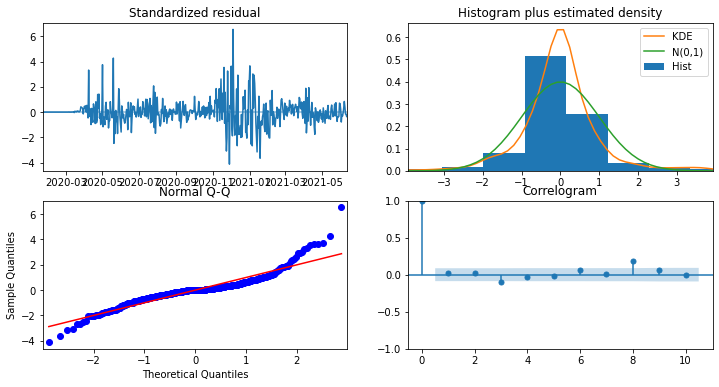

In [79]:
model = SARIMAX(train,order=auto_model.order, 
                seasonal_order =auto_model.seasonal_order,
                enforce_invertibility=False,freq='D').fit()
display(model.summary())
model.plot_diagnostics();

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                           # Cases   No. Observations:                  508
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -3472.575
Date:                           Mon, 09 Aug 2021   AIC                           6953.150
Time:                                   19:34:41   BIC                           6970.064
Sample:                               01-22-2020   HQIC                          6959.783
                                    - 06-12-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5763      0.027    -21.205      0.000      -0.630      -0.523
ar.S.L7        0.9627      0.023     41.633      0.000       0.917       1.008
ma.S.L7       -0.8219      0.042    -19.354      0.000      -0.905      -0.739
sigma2      5.162e+04   1747.061     29.545      0.000    4.82e+04     5.5e+04
===================================================================================
Ljung-Box (Q):                       80.87   Jarque-Bera (JB):               970.60
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.85   Skew:                             0.89
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Forecasted # Cases'}, xlabel='date'>)

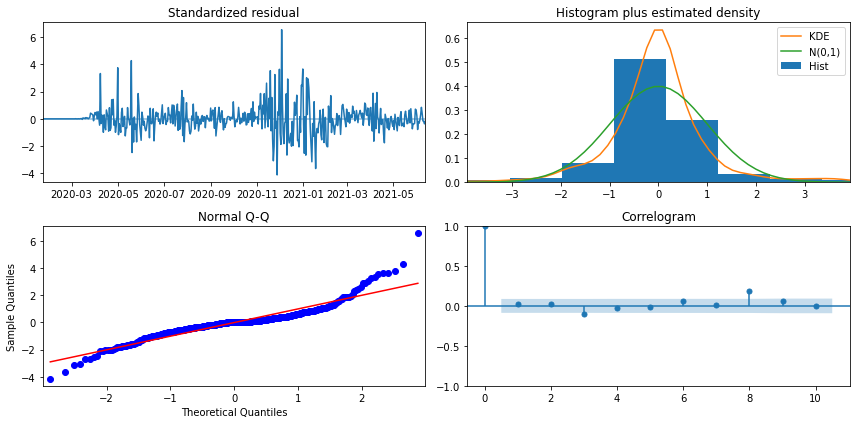

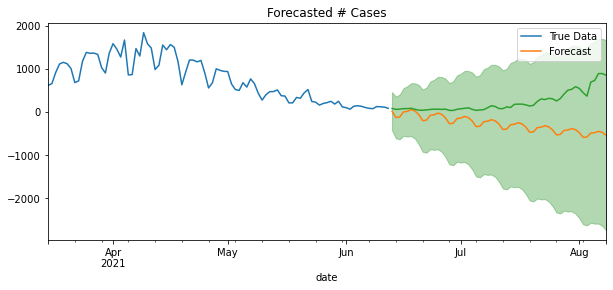

In [83]:
# fn.plot_forecast(model,)
fn.evaluate_model(model,train,test_ts=test,last_n_lags=90)

In [52]:
##Getting forecast
forecast = model.get_forecast(steps=14)

forecast_df = forecast.conf_int()
forecast_df['Forecast'] = forecast.predicted_mean
forecast_df.columns = ['lower','upper','forecast']
forecast_df

,lower,upper,forecast
2021-08-09,343.002656,1192.765671,767.884164
2021-08-10,307.683692,1231.798313,769.741002
2021-08-11,364.833640,1357.747777,861.290709
2021-08-12,365.934731,1423.180744,894.557737
2021-08-13,371.837854,1489.719683,930.778768
2021-08-14,347.189270,1522.583006,934.886138
2021-08-15,289.394791,1519.614724,904.504758
2021-08-16,188.213715,1513.767664,850.990690
2021-08-17,157.677119,1547.851160,852.764139
2021-08-18,214.241949,1666.162902,940.202426


[Text(0.5, 1.0, 'Forecasted Hospitalizations (Current) for Maryland')]

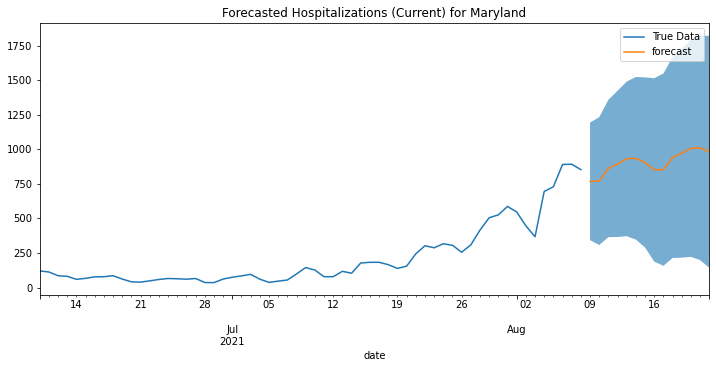

In [53]:
last_n_days = 60
fig,ax = plt.subplots(figsize=(12,5))
ts.iloc[-last_n_days:].plot(label='True Data')
forecast_df['forecast'].plot(ax=ax)
ax.fill_between(forecast_df.index,
                forecast_df['lower'], forecast_df['upper'],alpha=0.6)
ax.legend()
ax.set(title='Forecasted Hospitalizations (Current) for Maryland')
# ax.plot()

## NEXT: Functionize Forecasts

In [ ]:
from pmdarima import auto_arima

def get_ts(df,col,fill_val=np.nan,**kwargs):
    ts = df[col].fillna(value=fill_val)
    return ts



def get_best_model(ts,start_p=0,start_q=0,start_P=0,start_Q=0,m=7,
                   as_sarimax = True, **kwargs):
    
    auto_model = auto_arima(ts,start_p=start_p,
                            start_q=start_q,start_P=start_P,start_Q=start_Q,m=m,)
    print(f"[i] Best parameters found:")
    display(auto_model.summary())

    if as_sarimax:
        model = SARIMAX(ts,order=auto_model.order, 
                seasonal_order =auto_model.seasonal_order,
                enforce_invertibility=False,freq='D').fit()
        return model

    else:
        return auto_model

def get_forecast(model,steps=14):
    forecast = model.get_forecast(steps=steps)
    forecast_df = forecast.conf_int()
    forecast_df['Forecast'] = forecast.predicted_mean
    forecast_df.columns = ['lower','upper','forecast']
    return forecast_df

    
def plot_forecast(model,ts,last_n_days=60,future_steps=14):
    forecast_df = get_forecast(model,steps=future_steps)

    fig,ax = plt.subplots(figsize=(12,5))
    ts.iloc[-last_n_days:].plot(label='True Data')
    forecast_df['forecast'].plot(ax=ax)
    ax.fill_between(forecast_df.index,
                    forecast_df['lower'], forecast_df['upper'],alpha=0.6)
    ax.legend()
    ax.set(title=f'Forecasted {ts.name}')
    return fig,ax

In [ ]:
ts2 = get_ts(md,'hospitalizedCurrently',fill_val=0)
ts2 = ts2.loc['04-21-20':]
ts2.plot()

In [ ]:
auto_model2 = get_best_model(ts2)
auto_model2

In [ ]:
display(auto_model2.summary())
auto_model2.plot_diagnostics();


In [ ]:
plot_forecast(auto_model2,ts2)

# Bookmark: use functions to explore other data columns

In [ ]:
cols =[c for c in md.columns if 'current' in c.lower()]
cols.extend( ['positive','negative','death'])
cols

In [ ]:
df

In [ ]:
ts2 = get_ts(md,'inIcuCurrently',fill_val=0)
ts2 = ts2.loc['04-21-20':]
ts2.plot()

auto_model2 = get_best_model(ts2)
plot_forecast(auto_model2,ts2)

In [ ]:
df.head()

### Combined Function for State Forecasts

In [ ]:
def get_state_forecast(df, state_abbrev='NY', column='inIcuCurrently',
                       fill_val=np.nan, start_date ='04-21-20',
                       start_p=0,start_q=0,start_P=0,start_Q=0,m=7,
                       plot_last_n_days=180, future_steps=14,plot_ts=False):
    ## get state
    # state = df.groupby('state').get_group(state_abbrev)
    grouped = df.groupby(['state']).resample('D').last()
    state = grouped.loc[state_abbrev]

    ## Get ts 
    ts = get_ts(state,column,fill_val=fill_val)
    ts.name = f"{state_abbrev}-{column}"
    ts = ts.loc[start_date:]
    
    if plot_ts:
        ax = ts.plot(label=f"{column} for {state_abbrev}")
        ax.legend()

    print(f'[i] Starting grid search for {state_abbrev}-{column}')
    model = get_best_model(ts,start_p=start_p,start_q=start_q,start_P=start_P,
                           start_Q=start_Q,m=m)
    plot_forecast(model,ts,last_n_days=plot_last_n_days,future_steps=future_steps)
    return model,ts

In [ ]:
grouped.loc['CA']

In [ ]:
model,ts = get_state_forecast(df,fill_val=0,)

In [ ]:
# model,ts = get_state_forecast(df,state_abbrev='VA',  fill_val=0,)

In [ ]:
# states = ['MD','CA','MA','NY','PA','NJ']
# col = 'inIcuCurrently'


# for state in states:
#     dashes='---'*40
#     print(f"{dashes}\n\t{state}-{col}\n{dashes}" )

#     # print(f"{}")
#     model,ts = get_state_forecast(df,state_abbrev=state, column=col, fill_val=0,)
#     plt.show()

In [ ]:
# model,ts = get_state_forecast(df,state_abbrev='MA',  fill_val=0,)

In [ ]:
# model,ts = get_state_forecast(df,state_abbrev='VA',  fill_val=0,)

In [ ]:
# model,ts = get_state_forecast(df,state_abbrev='NJ',  fill_val=0,)

# Death/Ventilator Forecasts (compare to J.D. Capstone)

In [ ]:
death_states = ['NY', 'PA', 'NJ','IL','MI','MA']
grouped

In [ ]:
col = 'death'

for state in death_states:
    dashes='---'*40
    print(f"{dashes}\n\t{state}-{col}\n{dashes}" )

    # print(f"{}")
    model,ts = get_state_forecast(df,state_abbrev=state, column=col, fill_val=0,)
    model.plot_diagnostics()
    plt.show()

In [ ]:
col = 'onVentilatorCurrently'

for state in death_states:
    dashes='---'*40
    print(f"{dashes}\n\t{state}-{col}\n{dashes}" )

    # print(f"{}")
    model,ts = get_state_forecast(df,state_abbrev=state, column=col, fill_val=0,)
    display(model.plot_diagnostics())
    plt.show()